# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


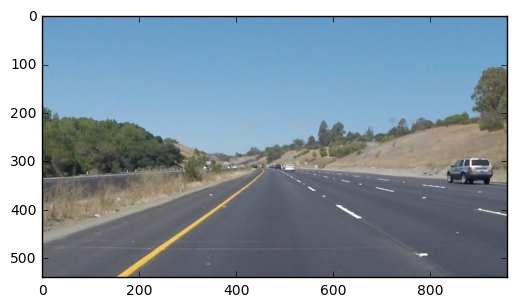

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidYellowCurve.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_vertices(img, vertices, color=[0, 255, 0], thickness=3):
    for i in range(0, vertices.shape[1]-1):
        cv2.line(img, (vertices[0][i][0], vertices[0][i][1]), (vertices[0][i+1][0], vertices[0][i+1][1]), color, thickness)

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope(lines):
    slopes = [] # list that contains the slope of all lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (x1 != x2):
                slopes.append((y2-y1)/(x2-x1))
            else:
                slopes.append(0)
    return np.array(slopes)
            
def slope_filter(lines, min_slope, max_slope):            
    slopes = slope(lines)
    return lines[np.where((slopes<max_slope) & (slopes>min_slope))[0],:,:]

def position_filter(lines, min_x, max_x):
    in_range = np.logical_and(np.logical_and(lines[:,0,0]>min_x,lines[:,0,0]<max_x),np.logical_and(lines[:,0,2]>min_x,lines[:,0,2]<max_x))
    return lines[np.where(in_range)[0],:,:]

# use opencv fitLine function
def fit_lines_cv(lines, y_min, y_max):
    x = np.append(lines[:,0,0],lines[:,0,2])
    y = np.append(lines[:,0,1],lines[:,0,3])
    points = np.column_stack((x,y))
    line = cv2.fitLine(points, 1, 0, 0.01, 0.01)
    def f(y):
        return line[0]*(y-line[3])/line[1]+line[2]
    return np.array([[(f(y_min), y_min, f(y_max), y_max)]]).astype(int)

# distance between point(x,y) and line(x=ay+b)
def distance(x,y,a,b):
    return a*a*np.square(x-a*y+b)+np.square(a*y-x+b)

def line2points(lines):
    x = []
    y = []
    step = 2
    for line in lines:
        for x1, y1, x2, y2 in line:
            p = x1
            # y = ax+b
            a = (y2-y1)/(x2-x1)
            b = y1 - a*x1
            while p<=x2:
                x.append(p)
                y.append(a*p+b)
                p = p+step
            x.append(x2)
            y.append(y2)
    return np.array(x), np.array(y)

def fit_lines(lines, y_min, y_max):
    # first, fit all lines to a single line
    x, y = line2points(lines)
    p = np.polyfit(y, x, 1) # linear fit
    
    # remove 10% points that has largest distance to the line
    distances = distance(x,y,p[0],p[1])
    points = np.column_stack((x,y,distances))
    points.view('float,float,float').sort(order=['f2'], axis=0)
    total = points.shape[0]
    n = int(total*0.1)
    
    # fit again
    x = points[:total-n,0]
    y = points[:total-n,1]
    p = np.polyfit(y, x, 1) 
    return np.array([[(p[0]*y_min+p[1], y_min, p[0]*y_max+p[1], y_max)]]).astype(int)

# divide lines into left and right lanes and then extropolate (with averaging) two lanes
def draw_lanes(img, lines, y_min, y_max, x_left, x_right, debug):
#     print('draw lanes', lines.shape)
    left_lines = lines
    right_lines = lines
    # apply slope filter 
    left_lines = slope_filter(left_lines, -0.9, -0.4)
    right_lines = slope_filter(right_lines, 0.3, 0.9)
#     print('after slope filter', left_lines.shape, right_lines.shape)
    # apply position filter
    left_lines = position_filter(left_lines, 0, x_left)
    right_lines = position_filter(right_lines, x_right, 9999)
#     print('after position filter', left_lines.shape, right_lines.shape)
    
    if debug:
        draw_lines(img, lines, [0, 0, 255], 3)# all detected lines
        draw_lines(img, left_lines, [0, 255, 255], 3)# lines for left lane after filtering
        draw_lines(img, right_lines, [255, 0, 255], 3)# lines for right lane after filtering
    
    # fit both lanes
    left_lines = fit_lines(left_lines, y_min, y_max)
    right_lines = fit_lines(right_lines, y_min, y_max)
    lanes = np.concatenate((left_lines, right_lines))
    draw_lines(img, lanes, [255,0,0], 8)

# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images
### Pipeline

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

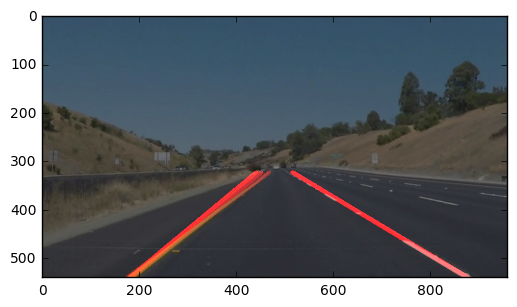

In [5]:
def pipeline(img):
    initial_img = img
    height = img.shape[0]
    length = img.shape[1]
    # canny edege detection constants
    low_threshold = 10
    high_threshold = 40
    kernel_size = 3
    # region of interest constants (assume left and right lanes are assymetric and the region is a trapeziod)
    top_y = int(0.6*height)
    bottom_x_margin_l = int(length/9)
    bottom_x_margin_r = int(length/12)
    top_x_width = (length/12)
    vertices = np.array([[(bottom_x_margin_l, height), (int(length/2-top_x_width), top_y), (int(length/2+top_x_width), top_y), (length-bottom_x_margin_r, height), (length-2*bottom_x_margin_r, height), (int(length/2), int(top_y+height/15)), (2*bottom_x_margin_l, height)]])
    # hough transform constanst
    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_len = 30
    max_line_gap = 10
    
    img = grayscale(img)
    img = canny(gaussian_blur(img, kernel_size), low_threshold, high_threshold)
    img = region_of_interest(img, vertices)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    debug = False
    if debug:
        draw_vertices(line_img, vertices)
    draw_lanes(line_img, lines, top_y, height, length*0.45, length*0.55, debug)
    img = weighted_img(line_img, initial_img)
    
    return img

import os
folder = 'test_images/'
prefix = 'processed_'
files = os.listdir(folder)
files.remove('.DS_Store')# remove the annoying auto generated file
img = mpimg.imread(folder + files[5])
processed_img = pipeline(img)
plt.imshow(processed_img)


## Test on images
### Process and save images

In [8]:
for file in files:
    img = mpimg.imread(folder + file)
    processed_img = pipeline(img)
    mpimg.imsave(folder + prefix + file, processed_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
####################################################################
# run this if getting "NeedDownloadError: Need ffmpeg exe" exception
# import imageio
# imageio.plugins.ffmpeg.download()
####################################################################
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 57.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.48 s, sys: 261 ms, total: 5.74 s
Wall time: 4.29 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:12<00:00, 53.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 16.5 s, sys: 805 ms, total: 17.3 s
Wall time: 13.2 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### Explaination of the pipeline
Here are the main steps of the pipelie:
* color image -> gray scale
* edge detection using canny (with gaussian blur)
* "region of interest" mask
* line detection using HoughLinesP
* filter, merge and extrapolate left/right lanes
* annotate lanes on original image

#### Filters
The major methods(algorithms) used are edege detection, line detection and line fitting. However, to actually make the pipeline work well on real videos, many filters are created to fine tuning the pipeline. 
##### region of interest filter
Since the the position of the lanes on the image are relatively fixed, only the region that the lanes can possibly fall into is considered. This is maybe the most important filter that can significanly reduce noises. The region of interest that I chose is a **Polygon**.
##### slope filter
Line slope is used to 1)divide lines into left and right lanes and, 2) filter lines that are not likely lanes (such as horizontal lines).

An observation is that lines on the left lane have a negative slope while lines on the right lane have a positive one. Moreover, the slopes of the left/right lanes are within a certain range. For example, a resonable range of the right lane is [0.5,1]. By applying slope range filter, a lot of noises can be filtered out (such as the car front (detected as horizontal lines) in the ```challenge.mp4``` video.
##### line position filter
Lines detected by hough line detector are divided into left and right lanes based on slope in the above step. Another observation is that lines that belong to the left lanes should reside on the left side of the image. By applying this constraint, we can further reduce noises. 
##### linear fitting outliers filter
There are still noises remaining after all the above filters. In the ```fit_lines``` function, I used some logic to further remove outliers. 

The logic contains 4 steps: 
1. transform lines to points. This is not only get the start and end points of each line, but also fill the "gaps" between the start and end points. The reasoning behind this is that longer lines(which are usually real traffic lanes) should have higher weights (or more points) in fitting.
2. fit the points and get a result line
3. remove 10% of points that have the largest distance to the line
4. fit the remaining points again

### Summary and future work
Although the pipeline works well on test images/videos provided, it may not work perfectly under various conditions. 
##### Drawbacks of the pipeline
* It relies on many heuristics (filters) and these heuristics may not work well on different conditions or requires fine tuning once condition is changed
* There are many parameters in this pipeline. Tuning of these parameters can be very tricky and time-consuming. 
* Robustness of this pipeline is a concern given the above reasons
##### Potential improvements
* Use better algorithms to drop outliers when fitting lines. Can use some clustering algorithms to find a subset of lines that are most likely lanes
* Introduce more heuristics to further drive down noises. Things to consider: 1) line color (usually while, yellow and red) 2) the fact that the left and right sides of a lane have the same color (usually black). 
* Make the algorithm smart enough to automatically adjust parameters. For example, the camera mount position could be different which results in different region of interst. By observing a few frames of the video the algorithm can automatically adjust the region of interest.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:09<00:00, 26.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 11.8 s, sys: 794 ms, total: 12.6 s
Wall time: 10.2 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))